In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.sparse as sps
from scipy.sparse.linalg import spsolve_triangular as spsolve_tri
from scipy.sparse.linalg import aslinearoperator
from scipy.sparse.linalg import spsolve, eigs

# Ayudantía 9

## Corrección SSOR

### Problema a estudiar:

$$\begin{alignat*}{3}
-\Delta u &= 0\quad& (x,y)\in(0,1)\times(0,1)=\Omega\\
u(x, y) &= g(x, y)\quad& (x,y)\in\partial\Omega
\end{alignat*}$$

$$g(x, y)=\begin{cases}\frac{2(y+1)}{y^2+2y+10} & x=0\\
\frac{2(y+1)}{y^2+2y+17} & x=1\\
\frac{2}{x^2+6x + 10} & y=0\\
\frac{4}{(3+x)^2+4} & y=1
\end{cases}$$

In [2]:
def FD2D_System(f, uD, N=50):
    """
    Dominio (abierto) de NxN puntos
    """
    h = 1./(N+1)
    M = int(N*N)
    A = np.zeros((M, M), dtype=float)
    b = np.zeros(M, dtype=float)
    
    for i in range(M):
        A[i, i] = 4
        if i < M-1 and (i+1)%N != 0:
            A[i, i+1] = -1
        if i > 0 and i%N!=0:
            A[i, i-1] = -1 
        if i + N < M:
            A[i, i+N] = -1
        if i - N >= 0:
            A[i, i-N] = -1
        
    # Hasta acá lo mismo de siempre.
    # Armamos el lado derecho
    for j in range(N):
        yj = (j+1)*h
        for i in range(N):
            xi = (i+1)*h
            b[i + j*N] += (h*h)*f([xi, yj])
            
            if j == 0:
                b[i + j*N] += uD([xi, 0])
            elif j == N-1:
                b[i + j*N] += uD([xi, 1])
            
            if i == 0:
                b[i + j*N] += uD([0, yj])
            elif i == N-1:
                b[i + j*N] += uD([1, yj])
    
    FreeNodes = np.array([i+k*(N+2) for k in range(1, N+1) for i in range(1, N+1)])
    
    return A, b, FreeNodes


def Fill_Boundary_Cond(uAprox, uD, FreeNodes, N):
    
    uh = uAprox.copy()
    M = uh.shape[0]
    h = 1/(N+1)
    BoundNodes = np.setdiff1d(np.arange(M), FreeNodes)
    
    for i in range(N+2):
        xi = i*h
        for j in range(N+2):
            yj = j*h
            if i + j*(N+2) in BoundNodes:
                uh[i + j*(N+2)] += uD([xi, yj])
    return uh

def Error(uh, sol):
    """
    Encuentra el máximo error punto a punto entre ambos.
    uh y sol son 2D
    """
    m, n = uh.shape
    uhnew = uh.reshape(m*n)
    solnew = sol.reshape(m*n)
    return np.linalg.norm(uhnew-solnew, ord=np.inf)

In [3]:
f = lambda x: 0

def uD(x):
    if abs(x[0]) < 1e-15:
        return (2*x[1] + 2)/(x[1]*x[1] + 2*x[1] + 10)
    elif abs(x[0] - 1) < 1e-15:
        return 2*(1 + x[1])/(x[1]*x[1] + 2*x[1] + 17)
    elif abs(x[1]) < 1e-15:
        return 2/(x[0]*x[0] + 6*x[0] + 10)
    elif abs(x[1] - 1) < 1e-15:
        return 4/((3+x[0])**2 + 4)
    return 0

### Para SOR:

In [4]:
def decompose(A):
    """
    If A = D-E-F, 
    return matrices D, E, F
    """
    m, n = A.shape
    E, F = np.zeros_like(A), np.zeros_like(A)
    D = np.diag(A.diagonal())
    for i in range(m):
        for j in range(i):
            E[i, j] = -A[i, j]
        for j in range(i+1, n):
            F[i, j] = -A[i, j]
    return D, E, F

def FD2D_sparse_decomposition(N):
    
    M = int(np.sqrt(N))
    D = sps.diags(np.ones(N, dtype=float)*4, shape=(N, N), format="csr")

    dataE = []
    rowE = []
    colE = []
    
    dataF = []
    rowF = []
    colF = []
    
    for i in range(N):
        if i < N-1 and (i+1)%M != 0:
            dataF.append(1)
            rowF.append(i)
            colF.append(i+1)
        if i + M < N:
            dataF.append(1)
            rowF.append(i)
            colF.append(i+M)
        if i > 0 and i%M!=0:
            dataE.append(1)
            rowE.append(i)
            colE.append(i-1)
        if i - M >= 0:
            dataE.append(1)
            rowE.append(i)
            colE.append(i-M)
    
    E = sps.csr_matrix((dataE, (rowE, colE)), shape=(N, N))
    F = sps.csr_matrix((dataF, (rowF, colF)), shape=(N, N))

    return D, E, F

def RadioEspectral(A, sparse=False):
    """
    Hay mejores formar de calcularlo!
    Esta es muy pesada :(
    """
    if not sparse:
        vals = np.linalg.eigvals(A)
        return max(abs(vals))
    
    vals = eigs(A, k=1, which="LM", return_eigenvectors=False)
    return abs(vals[0])

def omega_opt_SOR(D, E, F, sparse=False):
    if not sparse:
        BJ = np.linalg.solve(D, E + F) # Matriz iteracion Jacobi
        rJ = RadioEspectral(BJ, sparse=sparse)
    else:
        BJ = spsolve(D, E + F)         # Matriz iteracion Jacobi
        rJ = RadioEspectral(BJ, sparse=sparse)
    return 2./(1. + np.sqrt(1. - rJ**2))

def F_sub(L,b):
    '''
    Forward substitution algorithm for system L x = b
    input : L lower triangular matrix n x n
            b vector n x 1
    output: x solution of L x = b
    '''
    n = L.shape[0]
    x = np.zeros(n)
    x[0] = b[0]/L[0,0]
    for i in range(1,n):
        x[i] = (b[i] - L[i,0:i]@x[0:i])/L[i,i]
    return x

def B_sub(U,b):
    '''
    Backward substitution algorithm for system U x = b
    input : U upper tringular matrix n x n
            b vector n x 1
    output : x solution of U x = b
    '''
    n = U.shape[0]
    x = np.zeros(n)
    x[n-1] = b[n-1]/U[n-1,n-1]
    for i in range(n-2,-1,-1):
        x[i] = (b[i] - U[i,(i+1):n]@(x[(i+1):n]))/U[i,i]
    return x

### Distintas implementaciones de SSOR

In [17]:
def SSOR1(A, b, w=None, x0=None, tol=1e-14):
    """
    Symmetric SOR iteration to solve system Ax=b
    Starts at x0 = 0.
    Ends when |Ax-b| < tol.
    """
    m, n = A.shape
    D, E, F = decompose(A)
    t3 = time.time()
    
    #Parametro omega
    if w is None:
        w = omega_opt_SOR(D, E, F)
        t5 = time.time()
        print(f"ω óptimo = {w:.2f}") 
        print(f"El cálculo de ω óptimo demoró {t5-t3:.2f} segundos")
    
    # SOR iteration matrix and vector
    #Paso SOR original
    C1 = (1-w)*D + w*F
    D1 = D-w*E
    
    # Se agrega para SSOR
    C2 = (1-w)*D + w*E
    D2 = D-w*F
    
    #vectores 
    f1 = np.linalg.solve(D-w*E, w*b)
    f2 = np.linalg.solve(D-w*F, w*b)
    
    #Para evitar hacer  cosas innecesarias en cada iteración (ya que tenemos calculadas las inversas)
    c = np.linalg.solve(D-w*F, C2@f1)
    d = c + f2
    
    t4 = time.time()
    print(f"Se demoró {t4-t3:.2f} segundos en armar las matrices/vectores necesarios para iterar")
    
    # Initialization
    x = np.zeros(n, dtype=float)
    if x0 is not None:
        x = x0
    error = np.linalg.norm(A@x - b)
    i = 0
    
    t1 = time.time()
    
    while error > tol:
        i += 1
        x = np.linalg.solve(D2, C2@np.linalg.solve(D1, C1@x)) + d
        error = np.linalg.norm(A@x-b)
        print(f"\r{error:.3e}", end="")
        
    print(f"\nSe demoró {i} iteraciones en converger")
    t2 = time.time()
    print(f"Se demoró {t2-t1:.2f} segundos")
    return x

def SSOR2(A, b, w=None, x0=None, sparse=False, tol=1e-14):
    """
    Symmetric SOR iteration to solve system Ax=b
    Starts at x0 = 0.
    Ends when |Ax-b| < tol.
    """
    m, n = A.shape
    if sparse:
        D, E, F = FD2D_sparse_decomposition(m)
    else:
        D, E, F = decompose(A)
    
    t3 = time.time()
    
    #Parametro omega
    if w is None:
        t5 = time.time()
        w = omega_opt_SOR(D, E, F, sparse=sparse)
        print(f"ω óptimo = {w:.2f}")  
    
    t3 = time.time()
    print(f"El cálculo de ω óptimo demoró {t3-t5:.2f} segundos")
    
    # SOR iteration matrix and vector
    #Paso SOR original
    C1 = (1-w)*D + w*F
    D1 = D-w*E
    
    # Se agrega para SSOR
    C2 = (1-w)*D + w*E
    D2 = D-w*F
    
    #vectores 
    f1 = F_sub(D1, w*b)
    f2 = B_sub(D2, w*b)
    c = B_sub(D2, C2@f1)
    d = c + f2
    
    t4 = time.time()
    
    print(f"Se demoró {t4-t3:.2f} segundos en armar las matrices/vectores necesarios para iterar")
    
    # Initialization
    x = np.zeros(n, dtype=float)
    if x0 is not None:
        x = x0
    
    error = np.linalg.norm(A@x - b)
    i = 0
    
    t1 = time.time()
    
    while error > tol:
        i += 1
        x = B_sub(D2, C2@(F_sub(D1, C1@x))) + d
        error = np.linalg.norm(A@x - b)
        print(f"\r{error:.3e}", end="")
        
    t2 = time.time()
    print(f"\nSe demoró {i} iteraciones en converger")
    print(f"En total, demoró {t2-t1:.2f} segundos en hacer el ciclo de iteraciones")
    return x

def SSOR3(A, b, w=None, x0=None, tol=1e-14):
    """
    Symmetric SOR iteration to solve system Ax=b
    Starts at x0 = 0.
    Ends when |Ax-b| < tol.
    """
    m, n = A.shape
    D, E, F = FD2D_sparse_decomposition(m)
    
    #Parametro omega
    if w is None:
        t5 = time.time()
        w = omega_opt_SOR(D, E, F, sparse=True)
        print(f"ω óptimo = {w:.2f}")  
    
    t3 = time.time()
    
    print(f"El cálculo de ω óptimo demoró {t3-t5:.2f} segundos")
    # SOR iteration matrix and vector
    #Paso SOR original
    C1 = sps.triu((1-w)*D + w*F, format="csr")
    D1 = sps.tril(D-w*E, format="csr")
    
    # Se agrega para SSOR
    C2 = sps.tril((1-w)*D + w*E, format="csr")
    D2 = sps.triu(D-w*F, format="csr")
    
    #vectores 
    f1 = spsolve_tri(D1, w*b)
    f2 = spsolve_tri(D2, w*b, lower=False)
    c = spsolve_tri(D2, C2@f1, lower=False)
    d = c + f2
    
    t4 = time.time()
    
    print(f"Se demoró {t4-t3:.2f} segundos en armar las matrices/vectores necesarios para iterar")
    
    # Initialization
    x = np.zeros(n, dtype=float)
    if x0 is not None:
        x = x0
    error = np.linalg.norm(A@x - b)
    i = 0
    
    t1 = time.time()
    
    while error > tol:
        i += 1
        x = spsolve_tri(D2, C2@spsolve_tri(D1, C1@x), lower=False) + d
        error = np.linalg.norm(A@x - b)
        print(f"\r{error:.3e}", end="")
        
    t2 = time.time()
    print(f"\nSe demoró {i} iteraciones en converger")
    print(f"En total, demoró {t2-t1:.2f} segundos en hacer el ciclo de iteraciones")
    return x

In [6]:
def Solve_System_SSOR(f, uD, N=50, w=None, tipo=1, sparse=False):
    
    print("Armando el sistema....")
    t1 = time.time()
    A, b, FreeNodes = FD2D_System(f, uD, N=N)
    t2 = time.time()
    print(f"Se terminó de armar el sistema en {t2-t1:.2f} segundos")
    uAprox = np.zeros((N+2)*(N+2), dtype=float)
    
    # Llenamos los nodos interiores (a los que resolvemos)
    if tipo == 1:
        uAprox[FreeNodes] = SSOR1(A, b, w=w, tol=1e-8)
    elif tipo == 2:
        uAprox[FreeNodes] = SSOR2(A, b, w=w, sparse=sparse, tol=1e-8)
    else:
        uAprox[FreeNodes] = SSOR3(A, b, w=w, tol=1e-8)
    
    #Llenamos los nodos exteriores (condicion de borde Dirichlet)
    uAprox = Fill_Boundary_Cond(uAprox, uD, FreeNodes, N=N)
    uAprox = uAprox.reshape((N+2), (N+2))
    
    return uAprox

### Tests!

In [7]:
N = 40
w = None

#### Test con algoritmo 1: Implementación Naïve

In [18]:
uAprox = Solve_System_SSOR(f, uD, N=N, w=w, tipo=1)

Armando el sistema....
Se terminó de armar el sistema en 0.01 segundos
ω óptimo = 1.86
El cálculo de ω óptimo demoró 2.53 segundos
Se demoró 2.99 segundos en armar las matrices/vectores necesarios para iterar
9.403e-09
Se demoró 160 iteraciones en converger
Se demoró 26.03 segundos


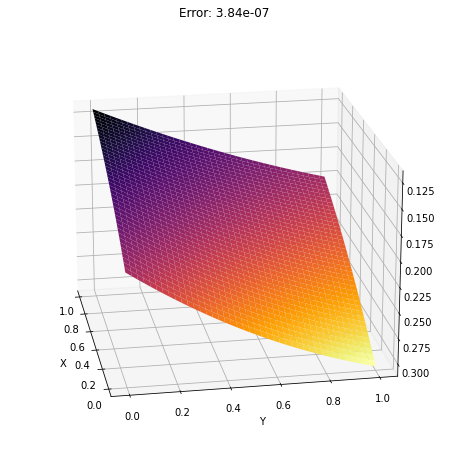

In [19]:
sol = lambda x: 2*(1+x[1])/((3+x[0])**2 + (1+x[1])**2)

t = np.linspace(0, 1, num=N+2)
X, Y = np.meshgrid(t, t)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, uAprox, cmap="inferno")
ax.view_init(200, 10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title(f"Error: {Error(uAprox, sol([X, Y])):.2e}")

plt.show()

#### Test 2: Con forward/backward substitution (para matrices densas) en matrices sparse.

In [20]:
uAprox = Solve_System_SSOR(f, uD, N=N, w=w, tipo=2, sparse=True)

Armando el sistema....
Se terminó de armar el sistema en 0.01 segundos
ω óptimo = 1.86
El cálculo de ω óptimo demoró 0.64 segundos
Se demoró 1.08 segundos en armar las matrices/vectores necesarios para iterar
9.403e-09
Se demoró 160 iteraciones en converger
En total, demoró 90.14 segundos en hacer el ciclo de iteraciones


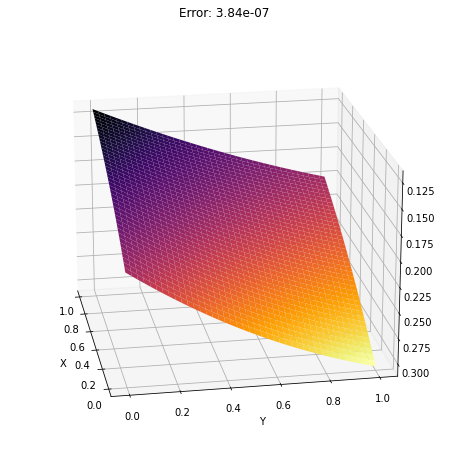

In [21]:
sol = lambda x: 2*(1+x[1])/((3+x[0])**2 + (1+x[1])**2)

t = np.linspace(0, 1, num=N+2)
X, Y = np.meshgrid(t, t)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, uAprox, cmap="inferno")
ax.view_init(200, 10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title(f"Error: {Error(uAprox, sol([X, Y])):.2e}")

plt.show()

#### Test 3: Forward/Backward Substitution para matrices densas con matrices densas

In [22]:
uAprox = Solve_System_SSOR(f, uD, N=N, w=w, tipo=2, sparse=False)

Armando el sistema....
Se terminó de armar el sistema en 0.01 segundos
ω óptimo = 1.86
El cálculo de ω óptimo demoró 2.62 segundos
Se demoró 0.09 segundos en armar las matrices/vectores necesarios para iterar
9.403e-09
Se demoró 160 iteraciones en converger
En total, demoró 3.49 segundos en hacer el ciclo de iteraciones


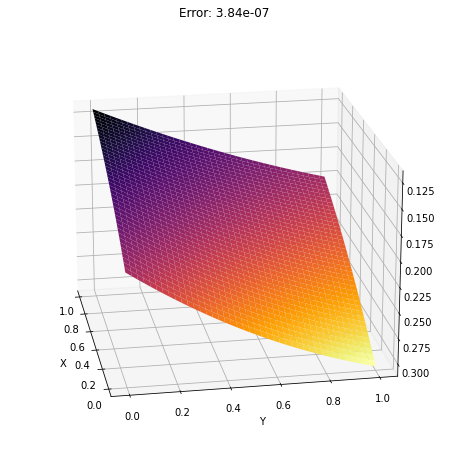

In [23]:
sol = lambda x: 2*(1+x[1])/((3+x[0])**2 + (1+x[1])**2)

t = np.linspace(0, 1, num=N+2)
X, Y = np.meshgrid(t, t)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, uAprox, cmap="inferno")
ax.view_init(200, 10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title(f"Error: {Error(uAprox, sol([X, Y])):.2e}")

plt.show()

#### Test 4: Sparse Everywhere

In [24]:
uAprox = Solve_System_SSOR(f, uD, N=N, w=w, tipo=3)

Armando el sistema....
Se terminó de armar el sistema en 0.01 segundos
ω óptimo = 1.86
El cálculo de ω óptimo demoró 0.69 segundos
Se demoró 0.14 segundos en armar las matrices/vectores necesarios para iterar
9.403e-09
Se demoró 160 iteraciones en converger
En total, demoró 11.12 segundos en hacer el ciclo de iteraciones


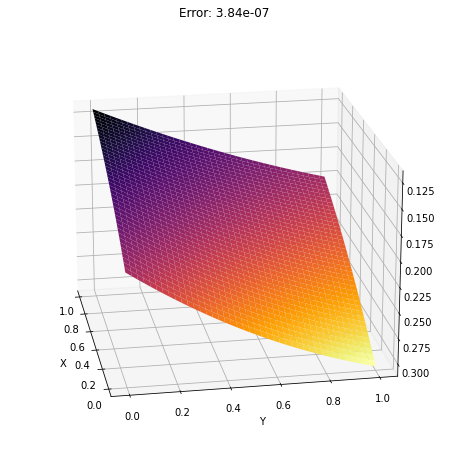

In [25]:
sol = lambda x: 2*(1+x[1])/((3+x[0])**2 + (1+x[1])**2)

t = np.linspace(0, 1, num=N+2)
X, Y = np.meshgrid(t, t)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, uAprox, cmap="inferno")
ax.view_init(200, 10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title(f"Error: {Error(uAprox, sol([X, Y])):.2e}")

plt.show()